In [2]:
import jovian
if True:
    pass
if False:
    jovian.commit(project='telecom-churn', filename='telecom_churn.ipynb')
    pass

## Telecom Case Study

#### Definitions
* Usage-based churn - Customers who have not had any usage in a 2 month period
* High-value customers - Customers who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

### Data
* 4 months of data available - June (6), July (7), August (8), September (9)
* Predict churn for last month (9th) using data from past 3 months

### Tagging churn
* Tag churn based on the last month (churn period). Customers who have no usage in this month have churned.
* **NOTE: Once churn is tagged, remove all attributes corresponding to the last month.**

Steps
1. describe(), info()
2. aggregate column names by column type
    1. Gather counts of columns in each list above
3. Print the percentage of missing values in each column - isnull().sum() / cnt * 100
4. Drop colums that have >= 70% values missing
5. Missing value imputations - ?
    1. Value that makes sense for continuous columns
    2. -1 (or equivalent) for categorica columns
6. Drop all date columns - ?
7. Calculate amount of recharge for months 6 and 7 - Done
8. Identify high-value customers using above step - Done
9. calculate total incoming & outgoing mou for 9th month
10. calculate total 2g & 3g data consumption for 9th month
11. Mark churn using the 2 above values - Done
12. EDA
    1. Univariate - distplot, countplot
    2. Bivariate - regplot
13. calculate diff col (8th - (6th + 7th)/2)
14. Divide x & y
15. Train-test split
    * stratify = yes - ???
16. Scaling
17. PCA
18. Logistic Regression
    * class_weight = balanced - ???
19. Stratified k-fold
    * n_splits=5, shuffle=True, random_state=4
20. GridSearchCV with RandomForest
21. Class imbalance
    * SMOTE - ???

TODO
1. Identify components that explain most variance
2. Plot scatterplots of these components
3. Order
  1. SMOTE
  2. PCA
  3. Modeling
4. Identify best model based on metric - **false negatives must be minimized**
5. Build intepretable model that achieves same metric or close enough.
6. **EDA - ???**

## 1. Read data

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/kavurisrikanth/telecom-churn-case-study/main/telecom_churn_data.csv')

In [5]:
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


## 2. Data preprocessing

In [6]:
data.mobile_number.is_unique

True

In [7]:
data.circle_id.value_counts()

109    99999
Name: circle_id, dtype: int64

mobile_number and circle_id are just identifiers; they do not add any value. So they can be dropped.

In [8]:
data.drop(['mobile_number', 'circle_id'], axis=1, inplace=True)

In [9]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 224 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    loc_og_t2o_mou            float64
 1    std_og_t2o_mou            float64
 2    loc_ic_t2o_mou            float64
 3    last_date_of_month_6      object 
 4    last_date_of_month_7      object 
 5    last_date_of_month_8      object 
 6    last_date_of_month_9      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   arpu_9                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   onnet_mou_9               float64
 15   offnet_mou_6              float64
 16   offnet_mou_7              float64
 17   offnet_mou_8              float64
 18   offnet_mou_9              float64
 19   roam_ic_mou_6             float64
 20   roam

aug_vbc_3g, jul_vbc_3g, jun_vbc_3g, and sep_vbc_3g are named in the wrong format. Correct them.

In [10]:
data = data.rename(columns={'aug_vbc_3g': 'vbc_3g_8', 'jul_vbc_3g': 'vbc_3g_7', 'jun_vbc_3g': 'vbc_3g_6', 'sep_vbc_3g': 'vbc_3g_9'})

No other obvious errors in columns.

## Tagging churn

In [11]:
usage_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

In [12]:
data['churn'] = data.apply(lambda x: 1 if x['total_ic_mou_9'] == 0 and x['total_og_mou_9'] == 0 and x['vol_2g_mb_9'] == 0 and x['vol_3g_mb_9'] == 0 else 0, axis=1)

In [13]:
data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,churn
0,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,...,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58,1
1,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,...,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00,0
2,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,...,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00,0
3,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,...,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00,0
4,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,...,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00,0


### Drop all columns for the last month

These columns cannot be used for learning.

In [14]:
month_9_cols = [x for x in data.columns if '_9' in x]

In [15]:
data.drop(month_9_cols, axis=1, inplace=True)

## Filtering high-value customers

High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [16]:
rech_amt_data_june = data['total_rech_data_6'] * data['av_rech_amt_data_6']
rech_amt_data_july = data['total_rech_data_7'] * data['av_rech_amt_data_7']

total_rech_amt_good_period = rech_amt_data_june.fillna(0) + rech_amt_data_july.fillna(0) + data['total_rech_amt_6'].fillna(0) + data['total_rech_amt_7'].fillna(0)

avg_total_rech_amt_good_period = total_rech_amt_good_period/2

avg_total_rech_70th = np.percentile(avg_total_rech_amt_good_period, 70)
print('70th percentile of average recharge amount in the good period: {:.2f}'.format(avg_total_rech_70th))

high_value = data[avg_total_rech_amt_good_period >= avg_total_rech_70th]
print('Number of High value customers:', high_value.shape[0])

data = high_value

70th percentile of average recharge amount in the good period: 478.00
Number of High value customers: 30001


## Missing values

In [17]:
def get_missing_data(cols):
    missing_dict = {}
    for x in cols:
        missing_dict[x] = [round(data[x].isna().sum() * 100.0 / data.shape[0], 2)]
    # print(missing_dict)
    missing_data = pd.DataFrame.from_dict(missing_dict, orient='index').reset_index()
    missing_data.columns = ['col', 'num_missing']
    missing_data.sort_values(by='num_missing', ascending=False, inplace=True)
    missing_data = missing_data[missing_data['num_missing'] != 0]
    return missing_data

In [18]:
missing_data = get_missing_data(data.columns)

In [19]:
# missing_data = round(data.isna().sum() / data.shape[0] * 100, 2).sort_values(ascending=False)
# missing_data = missing_data.rename(columns = ['col', 'missing'])

In [20]:
missing_data.columns

Index(['col', 'num_missing'], dtype='object')

In [21]:
missing_data.head(10)

,col,num_missing
122,total_rech_data_8,46.83
125,max_rech_data_8,46.83
164,fb_user_8,46.83
143,arpu_3g_8,46.83
149,night_pck_user_8,46.83
131,count_rech_3g_8,46.83
134,av_rech_amt_data_8,46.83
146,arpu_2g_8,46.83
119,date_of_last_rech_data_8,46.83
128,count_rech_2g_8,46.83


In [22]:
missing_data.num_missing.value_counts()

3.91     29
1.82     29
1.79     29
46.83    10
44.15    10
43.15    10
0.75      3
1.94      1
0.55      1
0.33      1
0.24      1
0.09      1
Name: num_missing, dtype: int64

In [23]:
missing_data.shape

(125, 2)

In [24]:
missing_data_over_40 = missing_data[missing_data['num_missing'] > 40]

In [25]:
missing_data_over_40.shape

(30, 2)

In [26]:
missing_data_over_40_cols = list(missing_data_over_40.col.values)

In [27]:
len(missing_data_over_40_cols)

30

In [28]:
sorted(missing_data_over_40_cols)

['arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8']

Drop columns with more than 40% values missing.

In [29]:
data.drop(missing_data_over_40_cols, axis=1, inplace=True)

In [30]:
data.shape

(30001, 140)

In [31]:
data.shape[0] * 3 / 100

900.03

Get the rest of the columns with data missing.

In [32]:
missing_data = get_missing_data(data.columns)

In [33]:
missing_data.head()

,col,num_missing
44,std_og_t2f_mou_8,3.91
59,og_others_8,3.91
20,roam_og_mou_8,3.91
23,loc_og_t2t_mou_8,3.91
65,loc_ic_t2t_mou_8,3.91


In [34]:
missing_cols = list(missing_data.col)

Even though the amount of missing data is relatively low, dropping the rows would result in a lot of data being lost.

### Missing value imputation

In [35]:
missing_mou = [x for x in missing_cols if 'mou' in x]

In [36]:
missing_non_mou = [x for x in missing_cols if x not in missing_mou]

In [37]:
data.shape

(30001, 140)

All the mou columns with values missing can be imputed with 0

In [38]:
for x in missing_mou:
    data[x] = data[x].fillna(0)

In [39]:
data.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn
0,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,0.00,...,1,1,0,0,0,968,30.40,0.00,101.20,1
7,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,...,0,0,0,0,0,802,57.74,19.38,18.74,1
8,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,...,0,0,0,0,0,315,21.03,910.65,122.16,0
21,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,514.453,597.753,637.760,102.41,...,0,0,0,0,0,720,0.00,0.00,0.00,0
23,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,74.350,193.897,366.966,48.96,...,2,1,0,0,1,604,40.45,51.86,0.00,0


Get missing columns again

In [40]:
missing_data = get_missing_data(data.columns)

In [41]:
missing_data

,col,num_missing
101,ic_others_8,3.91
59,og_others_8,3.91
113,date_of_last_rech_8,1.94
99,ic_others_6,1.82
57,og_others_6,1.82
100,ic_others_7,1.79
58,og_others_7,1.79
5,last_date_of_month_8,0.55
112,date_of_last_rech_7,0.33
111,date_of_last_rech_6,0.24


Since other columns are also either incoming or outgoing calls, they can be replaced with 0s too.

In [42]:
missing_others = [x for x in missing_cols if 'others' in x]

In [43]:
for x in missing_others:
    data[x] = data[x].fillna(0)

In [44]:
missing_data = get_missing_data(data.columns)

In [45]:
missing_data

,col,num_missing
113,date_of_last_rech_8,1.94
5,last_date_of_month_8,0.55
112,date_of_last_rech_7,0.33
111,date_of_last_rech_6,0.24
4,last_date_of_month_7,0.09


Since the rest of the missing values are in dates, it is best to drop the rows

In [46]:
data.shape

(30001, 140)

In [47]:
data.dropna(inplace=True)

In [48]:
get_missing_data(data.columns)

,col,num_missing


### Handling date columns

In [49]:
data.last_date_of_month_6.value_counts()

6/30/2014    29309
Name: last_date_of_month_6, dtype: int64

In [50]:
data.last_date_of_month_7.value_counts()

7/31/2014    29309
Name: last_date_of_month_7, dtype: int64

In [51]:
data.last_date_of_month_8.value_counts()

8/31/2014    29309
Name: last_date_of_month_8, dtype: int64

Some values are missing, but all the remaining values are just showing what the last date of the month is.

This can be inferred from the month itself, so the columns can be dropped.

In [52]:
last_date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']

In [53]:
data.shape

(29309, 140)

In [54]:
data.drop(last_date_cols, axis=1, inplace=True)

In [55]:
data.shape

(29309, 137)

#### All other date cols don't need month and year, since they are inferrable.

In [56]:
cols = data.columns

In [57]:
cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'churn'],
      dtype='object', length=137)

In [58]:
date_cols = [x for x in cols if 'date' in x]

In [59]:
date_cols

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [60]:
other_date_cols = [x for x in date_cols if x not in last_date_cols]

In [61]:
other_date_cols

['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [62]:
data[other_date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014
8,6/25/2014,7/31/2014,8/30/2014
21,6/30/2014,7/31/2014,8/31/2014
23,6/18/2014,7/7/2014,8/24/2014


In [63]:
def to_date(x):
    if pd.isna(x):
        return 0
    return pd.to_datetime(x).date().day

In [64]:
data['date_of_last_rech_6'].apply(lambda x: to_date(x))

0        21
7        27
8        25
21       30
23       18
         ..
99981    17
99984    21
99986    20
99988    30
99997    17
Name: date_of_last_rech_6, Length: 29309, dtype: int64

In [65]:
for col in other_date_cols:
    data.loc[~data[col].isna(), col] = pd.to_datetime(data[~data[col].isna()][col], errors='coerce').dt.day
    # data[col] = data[col].apply(lambda x: to_date(x))

In [66]:
data[other_date_cols].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,21,16,8
7,27,25,26
8,25,31,30
21,30,31,31
23,18,7,24


## Feature Selection

Collect columns with single value

In [67]:
single_cols = []

for x in data.columns:
    if (data[x].nunique() == 1):
        single_cols.append(x)

In [68]:
len(single_cols)

9

In [69]:
single_cols

['loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

Drop all these columns

In [70]:
data.drop(single_cols, axis=1, inplace=True)

In [71]:
data.shape

(29309, 128)

### Handling outliers

In [72]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29309 entries, 0 to 99997
Data columns (total 128 columns):
 #    Column               Dtype  
---   ------               -----  
 0    arpu_6               float64
 1    arpu_7               float64
 2    arpu_8               float64
 3    onnet_mou_6          float64
 4    onnet_mou_7          float64
 5    onnet_mou_8          float64
 6    offnet_mou_6         float64
 7    offnet_mou_7         float64
 8    offnet_mou_8         float64
 9    roam_ic_mou_6        float64
 10   roam_ic_mou_7        float64
 11   roam_ic_mou_8        float64
 12   roam_og_mou_6        float64
 13   roam_og_mou_7        float64
 14   roam_og_mou_8        float64
 15   loc_og_t2t_mou_6     float64
 16   loc_og_t2t_mou_7     float64
 17   loc_og_t2t_mou_8     float64
 18   loc_og_t2m_mou_6     float64
 19   loc_og_t2m_mou_7     float64
 20   loc_og_t2m_mou_8     float64
 21   loc_og_t2f_mou_6     float64
 22   loc_og_t2f_mou_7     float64
 23   loc_og_t2

In [73]:
numeric_cols = list(data.columns)

In [74]:
remove = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'aon']

In [75]:
numeric_cols = [x for x in numeric_cols if x not in remove]

In [76]:
data.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn
count,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,...,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000
mean,557.336657,565.213995,516.702002,261.675662,270.536172,238.021534,372.857161,379.977659,339.253170,16.170494,...,0.230919,0.215565,0.209424,0.229793,0.206865,1212.336893,172.360443,180.765627,159.025671,0.071207
std,451.521621,479.692319,501.839797,458.657053,481.785178,461.543860,479.020477,497.513960,480.144122,76.336762,...,0.662131,0.623623,0.989307,1.099079,1.112370,957.495084,424.851933,446.690526,417.953770,0.257174
min,-810.661000,-622.509000,-345.129000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,311.327000,314.978000,241.340000,17.510000,16.760000,11.800000,72.610000,71.630000,51.460000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,463.000000,0.000000,0.000000,0.000000,0.000000
50%,481.940000,484.115000,434.472000,85.740000,85.080000,68.630000,223.010000,223.060000,188.290000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,849.000000,0.000000,0.000000,0.000000,0.000000
75%,697.944000,701.116000,666.371000,292.710000,295.210000,245.780000,487.460000,496.230000,444.840000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1764.000000,137.340000,141.040000,98.750000,0.000000
max,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,9667.130000,14007.340000,2613.310000,...,16.000000,16.000000,29.000000,35.000000,41.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.000000


Many columns contain outliers. The large values could be meaningful, but in the absence of business context, we must impute these values.

In [77]:
for col in numeric_cols:
    q3 = np.percentile(data[col], 75)
    q1 = np.percentile(data[col], 25)
    iqr = q3 - q1

    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr

    imp = np.percentile(data[col], 99)

    data.loc[(data[col] < lo) | (data[col] > hi), col] = imp

In [78]:
data.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,churn
count,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,...,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000,29309.000000
mean,563.371481,573.329136,521.478985,353.686666,369.626877,345.172141,409.435336,417.495199,372.440434,73.177031,...,0.472995,0.448838,0.430448,0.535672,0.452762,1212.336893,351.744531,366.701948,370.421937,0.071207
std,401.394432,413.499496,427.180350,647.623768,678.174595,668.828189,560.642267,577.542512,535.828067,140.932884,...,1.093298,1.070093,1.239580,1.546446,1.434882,957.495084,727.244658,759.290391,748.258697,0.257174
min,-185.043000,-179.027000,-345.129000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,311.338000,315.069000,241.340000,17.510000,16.760000,11.800000,72.610000,71.630000,51.460000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,463.000000,0.000000,0.000000,0.000000,0.000000
50%,481.996000,484.149000,434.472000,85.740000,85.080000,68.630000,223.010000,223.060000,188.290000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,849.000000,0.000000,0.000000,0.000000,0.000000
75%,698.000000,701.229000,666.371000,292.710000,295.210000,245.780000,487.460000,496.230000,444.840000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1764.000000,137.340000,141.040000,98.750000,0.000000
max,1960.213480,1999.399600,1987.958120,2149.408400,2213.032400,2165.296400,2298.902400,2375.928400,2190.152000,344.592800,...,3.000000,3.000000,4.000000,5.000000,5.000000,4321.000000,1985.571600,2075.243600,1954.116400,1.000000


### Deriving new features

Since our method of detecting churn is based on usage, checking the difference in certain columns between months 6 & 7, and month 8 could be helpful.

In [79]:
add_diff_cols = ['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'std_ic_mou', 'std_og_mou', 'loc_ic_mou', 'loc_og_mou', 'isd_ic_mou', 'isd_og_mou', 'spl_ic_mou', 'spl_og_mou', 'total_ic_mou', 'total_og_mou', 'total_rech_amt', 'total_rech_num', 'max_rech_amt', 'vol_2g_mb', 'vol_3g_mb', 'vbc_3g']

In [80]:
for col in add_diff_cols:
    jun = col + '_6'
    jul = col + '_7'
    aug = col + '_8'
    if jun not in data.columns:
        print(f'{jun} not found.')
    elif jul not in data.columns:
        print(f'{jul} not found.')
    elif aug not in data.columns:
        print(f'{aug} not found.')
    else:
        data[col + '_diff'] = data[aug] - ((data[jun] + data[jul])/2)

## EDA

With the difference columns, we can check whether there is a relationship between the difference value and a customer churning.

<Figure size 864x288 with 0 Axes>

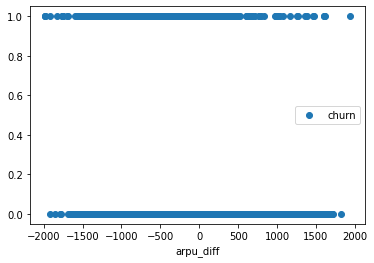

In [81]:
plt.figure(figsize=(12, 4))
data.plot(x='arpu_diff', y='churn', style=['o', 'rx'])
plt.show()

In [82]:
def plot_scatter(col):
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=col, y='churn', data=data)
    plt.axvline(color='r')
    plt.title(col + ' vs. Churn')
    # data.plot(x='arpu_diff', y='churn', style=['o', 'rx'])
    plt.show()

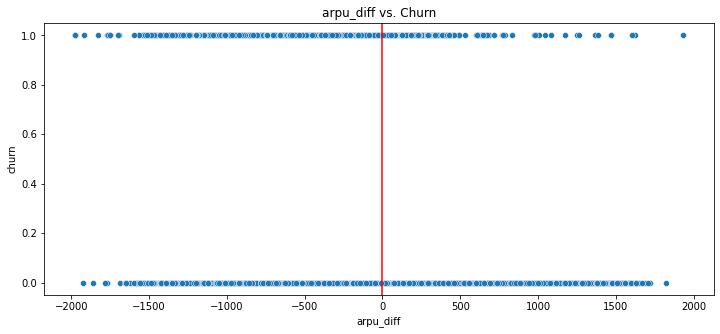

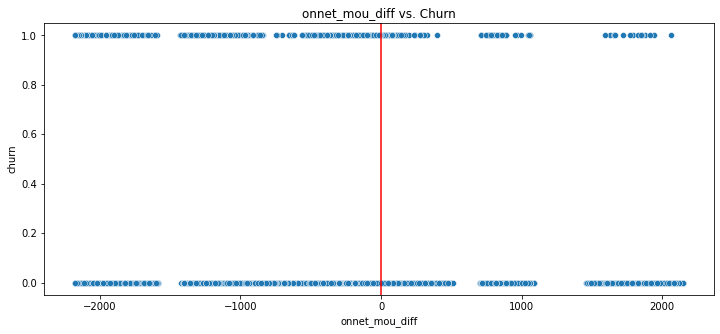

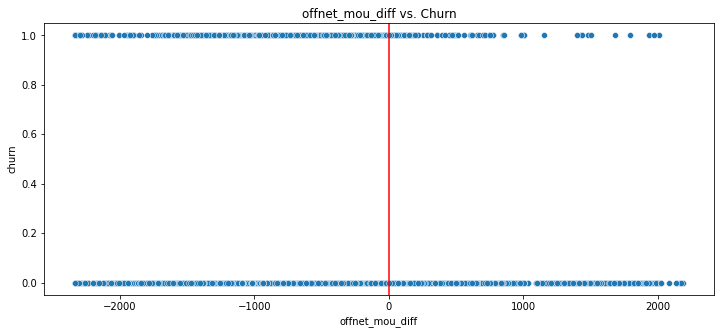

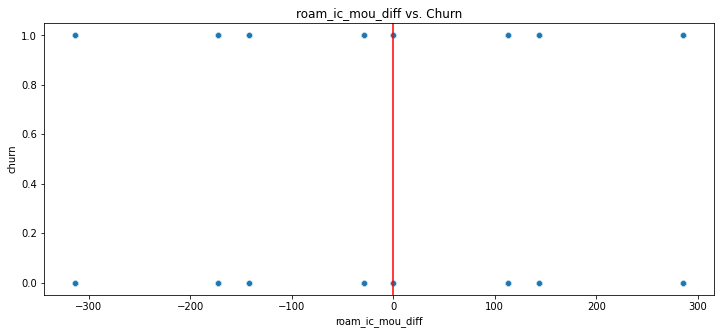

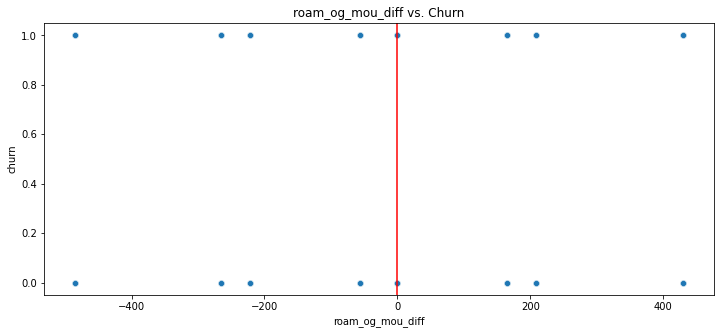

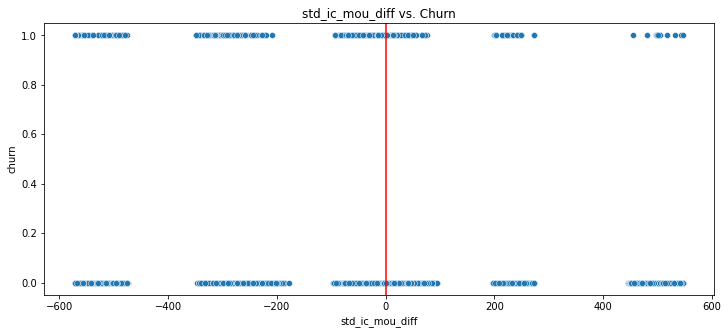

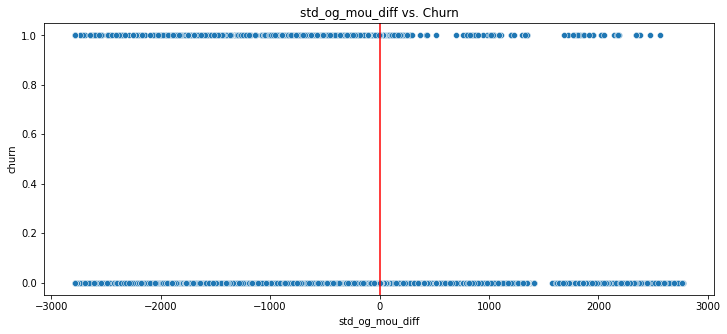

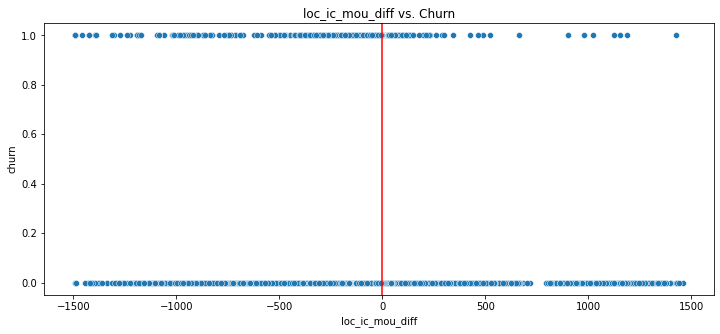

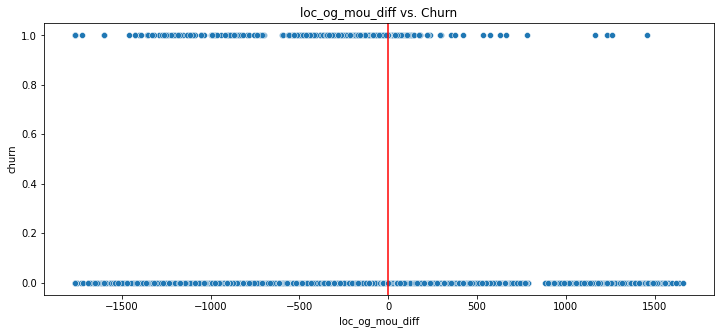

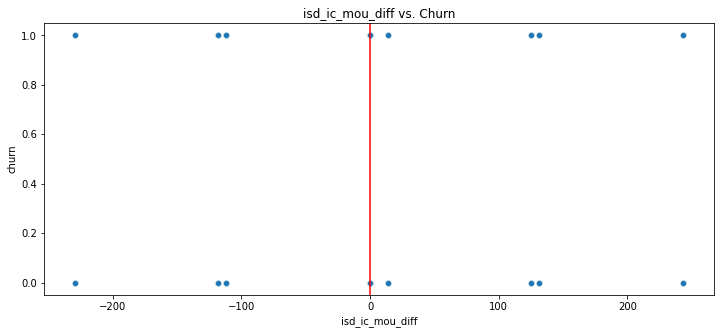

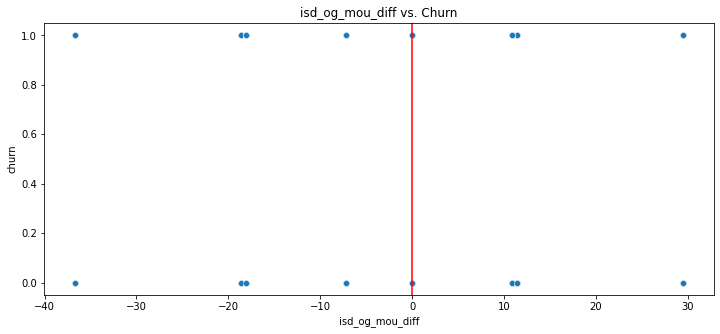

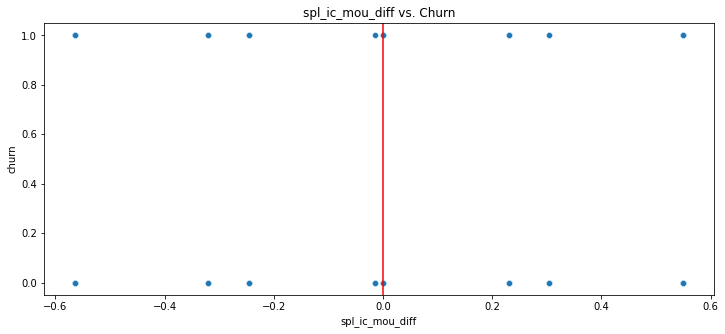

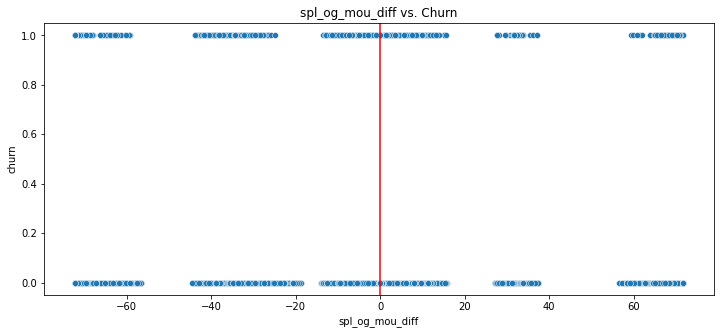

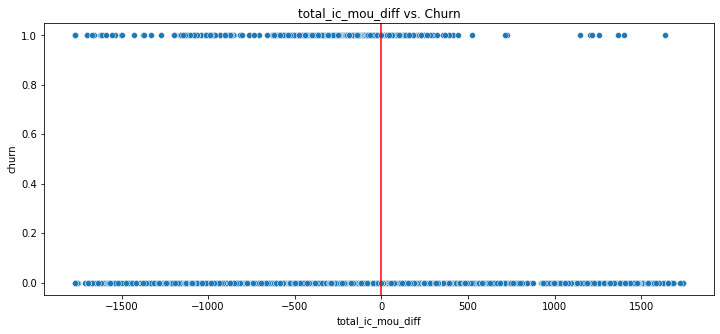

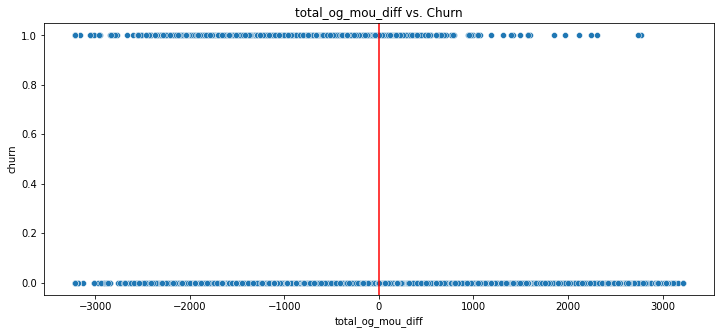

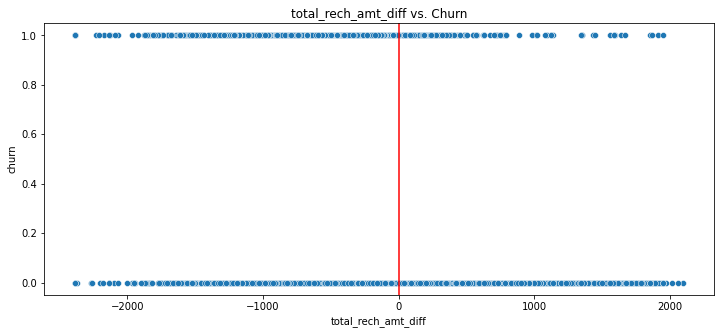

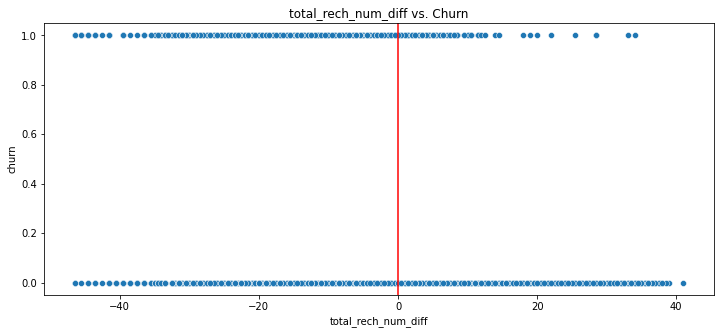

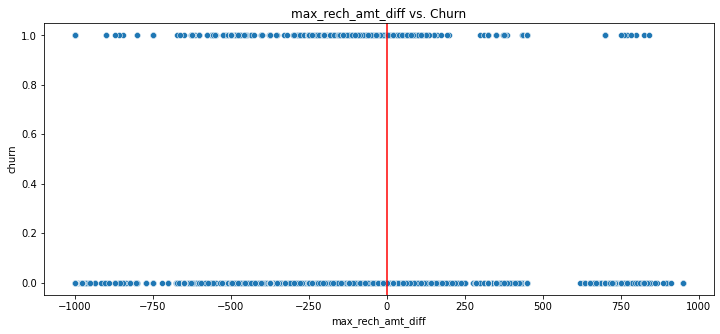

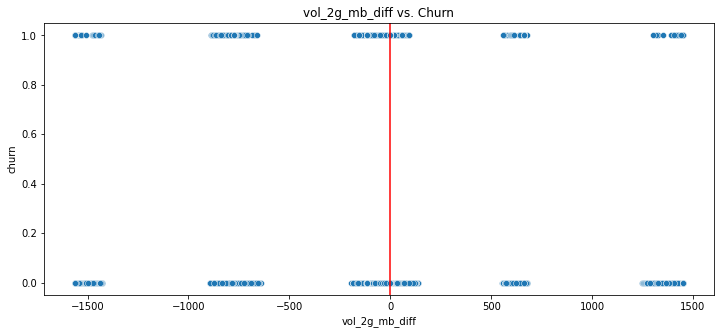

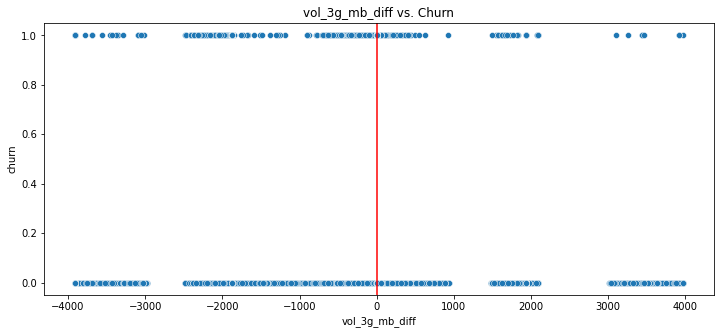

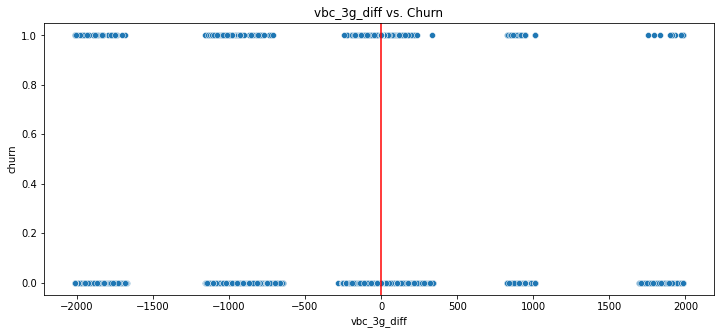

In [83]:
for x in add_diff_cols:
    plot_scatter(x + '_diff')

The general trend is that when the difference is negative i.e., when the usage in August is less than the average usage in June and July, the customer is more likely to churn.

**MAYBE**

### Univariate analysis

In [84]:
if False:
    non_id_cols = [x for x in data.columns if x not in id_cols and x != 'churn']
    data['arpu_6'].value_counts()
    non_id_cols
    mou_cols = [x for x in non_id_cols if 'mou' in x]

In [85]:
def plot_cols(cols):
    idx = 0
    for x in cols:
        plt.figure(figsize=(12, 4))
        print('*** ' + x + ' ***')
        sns.countplot(data=data, x=x, hue='churn')
        plt.show()
        print('')

        idx += 1

In [86]:
# plot_cols(mou_cols)

### Bivariate analysis

**MAYBE**

## Train-test split

In [87]:
def split_x_and_y(df):
    y = df.pop('churn')
    X = df

    return X, y

In [88]:
X, y = split_x_and_y(data)

In [89]:
from sklearn.model_selection import train_test_split

X_train_base, X_test_base, y_train_base, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [90]:
X_train_base.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,spl_ic_mou_diff,spl_og_mou_diff,total_ic_mou_diff,total_og_mou_diff,total_rech_amt_diff,total_rech_num_diff,max_rech_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,vbc_3g_diff
48473,921.429,1999.3996,1987.95812,2149.4084,2213.0324,2165.2964,502.24,2375.9284,2190.152,344.5928,...,0.000,69.6260,39.8050,0.7684,546.88,12.0,25.0,1427.1742,0.000,0.0000
51978,266.622,354.0770,286.74500,62.7800,35.1100,19.8100,116.11,99.3900,59.030,0.0000,...,-0.245,0.8650,-138.9150,-85.5650,-2.50,0.0,-32.0,661.8210,0.000,0.0000
66246,619.069,566.4140,447.87100,62.9800,12.0900,16.9800,247.48,132.8800,105.980,0.0000,...,-0.245,-1.0200,-25.4200,-104.7600,-121.00,-34.5,158.0,-112.7736,-223.425,-977.0582
21087,20.587,333.1490,116.85000,12.7900,0.0000,4.6900,26.58,146.1400,76.330,0.0000,...,0.000,32.9564,-16.9300,-15.0950,-373.50,1.0,-560.0,661.8210,0.000,0.0000
36017,340.992,514.6900,456.49500,357.7800,2213.0324,2165.2964,266.24,188.0100,175.640,0.0000,...,0.000,3.7000,-28.4342,75.3250,-61.00,-3.5,22.0,0.0000,0.000,0.0000


In [91]:
X_test_base.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,spl_ic_mou_diff,spl_og_mou_diff,total_ic_mou_diff,total_og_mou_diff,total_rech_amt_diff,total_rech_num_diff,max_rech_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,vbc_3g_diff
76781,391.79300,794.124,688.505,129.3600,87.43,72.21,246.9600,715.31,846.99,0.0000,...,-0.320,3.2250,-406.8382,328.930,142.00,-4.5,20.0,0.0000,0.000,0.0
8481,812.74200,114.387,17.749,92.4400,3.18,13.01,2298.9024,263.81,2.78,0.0000,...,-0.565,0.0000,-13.4700,-1048.810,-458.00,-2.0,-495.0,0.0000,0.000,0.0
97807,422.09200,466.068,339.856,33.8300,42.43,22.29,573.8800,549.99,401.86,0.0000,...,-0.320,-0.2650,-28.4342,-175.255,-283.00,-2.5,21.0,0.0000,0.000,0.0
10702,567.79700,236.907,457.694,154.7600,77.54,86.89,546.2100,204.19,483.16,344.5928,...,0.000,-32.5396,-26.9400,-205.435,49.50,5.5,-23.0,-774.5946,0.000,0.0
1931,1960.21348,213.752,336.071,2149.4084,0.76,45.78,2298.9024,94.06,203.83,0.0000,...,0.550,-64.5492,-52.8900,-1479.857,-907.96,-19.5,74.0,-1564.7528,-1.175,0.0


Checking distribution of values in the datasets.

In [92]:
y.value_counts(normalize=True)

0    0.928793
1    0.071207
Name: churn, dtype: float64

In [93]:
y_train_base.value_counts(normalize=True)

0    0.928787
1    0.071213
Name: churn, dtype: float64

In [94]:
y_test.value_counts(normalize=True)

0    0.928807
1    0.071193
Name: churn, dtype: float64

### Try to fix class imbalance using SMOTE

In [95]:
%pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
from imblearn.over_sampling import SMOTE

In [97]:
smote = SMOTE(random_state=42)

In [98]:
X_train_sm, y_train_sm = smote.fit_resample(X_train_base, y_train_base)

## Scaling

In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test_base)

## Modeling - Logisitic Regression

Perform logistic regression to find the best columns that influence churn.

In [101]:
import statsmodels.api as sm

In [102]:
X_train_lr = pd.DataFrame(data=X_train_scaled, columns=X_train_base.columns)
y_train_lr = y_train_sm

X_test_lr = pd.DataFrame(data=X_test_scaled, columns=X_test_base.columns)
y_test_lr = y_test

In [103]:
X_train_lr.shape

(38110, 148)

In [104]:
X_train_base.shape

(20516, 148)

In [105]:
X_train_lr

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,spl_ic_mou_diff,spl_og_mou_diff,total_ic_mou_diff,total_og_mou_diff,total_rech_amt_diff,total_rech_num_diff,max_rech_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,vbc_3g_diff
0,0.804211,3.457991,3.821025,2.347887,2.602112,3.156839,0.073684,3.208385,3.977831,1.959346,...,0.315453,3.433567,0.395388,0.404396,1.720661,1.989447,0.406542,3.432848,0.090066,0.116188
1,-0.783185,-0.498589,-0.266455,-0.512234,-0.510254,-0.410525,-0.545497,-0.534301,-0.454148,-0.571661,...,-1.106645,0.172922,-0.301656,0.274596,0.504592,0.529892,0.064894,1.685401,0.090066,0.116188
2,0.071224,0.012027,0.120680,-0.511960,-0.543150,-0.415230,-0.334838,-0.479243,-0.356509,-0.571661,...,-1.106645,0.083536,0.140998,0.245737,0.242289,-3.666329,1.203719,-0.083146,-0.150916,-1.800269
3,-1.379628,-0.548916,-0.674659,-0.580754,-0.560428,-0.435665,-0.689063,-0.457443,-0.418170,-0.571661,...,0.315453,1.694696,0.174110,0.380546,-0.316628,0.651521,-3.099841,1.685401,0.090066,0.116188
4,-0.602896,-0.112356,0.141401,-0.107880,2.602112,3.156839,-0.304755,-0.388608,-0.211641,-0.571661,...,0.315453,0.307358,0.129242,0.516490,0.375100,0.104188,0.388560,0.174338,0.090066,0.116188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38105,-1.146620,-0.732068,-0.871789,-0.398394,-0.437951,-0.434603,-0.715992,-0.684408,-0.567675,-0.571661,...,-1.511556,0.127581,0.220354,0.234024,0.103893,0.161018,-0.550814,0.378903,2.176859,0.424071
38106,0.587611,0.217566,-0.481314,2.347887,2.602112,-0.351874,-0.164523,-0.386311,-0.221204,-0.571661,...,0.315453,-2.232138,-0.201253,-1.443086,-0.912543,-0.264407,0.140622,0.174338,0.090066,0.116188
38107,-0.046218,-0.744892,-0.538690,-0.218414,-0.436876,-0.422309,0.523135,-0.466541,-0.392763,-0.571661,...,0.007833,-0.105281,-0.364490,-0.419351,-0.187005,-0.118160,0.196758,0.174338,0.090066,0.116188
38108,1.157012,1.048050,0.746335,2.347887,2.602112,3.156839,-0.407741,-0.265256,0.113716,-0.571661,...,0.315453,0.172852,-0.155192,-1.989376,-0.444471,-0.608616,0.187113,0.174405,0.090066,0.116188


In [106]:
X_test_lr

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,spl_ic_mou_diff,spl_og_mou_diff,total_ic_mou_diff,total_og_mou_diff,total_rech_amt_diff,total_rech_num_diff,max_rech_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,vbc_3g_diff
0,-0.479743,0.559611,0.698848,-0.420973,-0.435486,-0.323398,-0.335672,0.478287,1.184529,-0.571661,...,-1.541981,0.284833,-1.346612,0.897779,0.824447,-0.017441,0.376573,0.174338,0.090066,0.116188
1,0.540730,-1.074983,-0.912768,-0.471579,-0.555883,-0.421831,2.954732,-0.263991,-0.571128,-0.571661,...,-2.964080,0.131904,0.187605,-1.173619,-0.503671,0.286633,-2.710243,0.174338,0.090066,0.116188
2,-0.406291,-0.229280,-0.138846,-0.551915,-0.499793,-0.406401,0.188563,0.206496,0.258817,-0.571661,...,-1.541981,0.119338,0.129242,0.139749,-0.116303,0.225818,0.382566,0.174338,0.090066,0.116188
3,-0.053070,-0.780353,0.144282,-0.386158,-0.449619,-0.298989,0.144192,-0.362007,0.427892,1.959346,...,0.315453,-1.411123,0.135069,0.094374,0.619695,1.198854,0.118839,-1.594209,0.090066,0.116188
4,3.322453,-0.836035,-0.147940,2.347887,-0.559342,-0.367343,2.954732,-0.543064,-0.153016,-0.571661,...,3.507918,-2.929017,0.033859,-1.821688,-1.499671,-1.841885,0.700239,-3.398291,0.088799,0.116188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8788,-0.820324,0.800781,0.161605,-0.451635,-0.360303,-0.297742,-0.461278,-0.204181,-0.236804,-0.571661,...,0.315453,-3.298419,-0.400215,0.266740,0.211299,0.286633,0.262690,0.242399,3.964215,1.975550
8789,-0.571798,-0.490276,-0.121150,-0.506230,-0.418294,-0.328419,-0.420612,-0.408040,-0.097593,-0.571661,...,-2.964080,0.104249,1.034691,0.439527,0.568784,0.773151,0.076882,1.486158,0.090066,0.116188
8790,-0.911196,-0.835886,0.138008,-0.598286,-0.560428,-0.443463,-0.731686,-0.697701,-0.576910,-0.571661,...,0.315453,0.131904,0.240141,0.403241,1.140982,0.590707,-0.180852,0.206713,1.823668,0.249861
8791,0.269273,3.457991,1.601938,2.347887,2.602112,3.156839,-0.338157,-0.434016,-0.314854,-0.571661,...,0.315453,0.015488,0.574213,0.404396,-0.577736,-0.139071,-0.037001,-0.083146,-0.007567,0.177434


Try to reduce the number of columns with RFE.

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [108]:
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=50)
rfe = rfe.fit(X_train_lr, y_train_lr)

In [109]:
supported = X_train_lr.columns[rfe.support_]

In [110]:
X_train_lr_reduced = X_train_lr[supported]

In [111]:
def get_informedness(y, y_pred):
    conf = confusion_matrix(y_pred=y_pred, y_true=y)
    tp = conf[0][0]
    fn = conf[0][1]
    fp = conf[1][0]
    tn = conf[1][1]

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    informedness = tpr + tnr - 1

    return np.round(informedness, 2)

def get_sensitivity(y, y_pred):
    conf = confusion_matrix(y_pred=y_pred, y_true=y)
    tp = conf[0][0]
    fn = conf[0][1]
    fp = conf[1][0]
    tn = conf[1][1]

    sensitivity = tp / (tp + fn)
    return np.round(sensitivity, 2)

def get_specificity(y, y_pred):
    conf = confusion_matrix(y_pred=y_pred, y_true=y)
    tp = conf[0][0]
    fn = conf[0][1]
    fp = conf[1][0]
    tn = conf[1][1]

    specificity = tn / (tn + fp)
    return np.round(specificity, 2)

def get_accuracy(y, y_pred):
    return np.round(accuracy_score(y_pred=y_pred, y_true=y), 2)

def evaluate(y, y_pred):
    acc = get_accuracy(y, y_pred)
    print('')
    print(f'*** accuracy: {acc}')

    print('')
    print(f'*** sensitivity: {get_sensitivity(y, y_pred)}')

    print('')
    print(classification_report(y_pred=y_pred, y_true=y))
    print('')

    print(f'*** informedness: {get_informedness(y, y_pred)}')

    roc_auc = np.round(roc_auc_score(y_score=y_pred, y_true=y), 2)
    print(f'*** ROC AUC: {roc_auc}')


In [112]:
def check_vif(df, cols):
    vif = pd.DataFrame()
    vif['Features'] = cols
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def calculate_vif(df):
    features = list(df.columns)
    vif = check_vif(df, features)
    return vif

In [113]:
glm = sm.GLM(y_train_lr, sm.add_constant(X_train_lr_reduced), family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38110
Model:                            GLM   Df Residuals:                    38059
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13080.
Date:                Mon, 03 Oct 2022   Deviance:                       26160.
Time:                        18:44:48   Pearson chi2:                 5.95e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3087      0.018    -16.919      0.000      -0.344      -0.273
arpu_7                  0.4046      0.029     13.867      0.000       0.347       0.462
onnet_mou_7            -0.1319      0.025     -5.372      0.000      -0.180      -0.084
roam_og_mou_6           0.1758      0.024      7.218      0.000       0.128       0.223
roam_og_mou_8           0.4975      0.027     18.520      0.000       0.445       0.550
loc_og_t2t_mou_8       -0.1631      0.028     -5.894      0.000      -0.217      -0.109
loc_og_t2m_mou_8       -0.4914      0.038    -13.097      0.000      -0.565      -0.418
loc_og_mou_7            0.1340      0.033      4.098      0.000       0.070       0.198
std_og_t2t_mou_8       -0.1681      0.022     -7.739      0.000      -0.211      -0.126
std_og_t2m_mou_8       -0.1952      0.019    -10.262      0.000      -0.232      -0.158
std_og_mou_6            0.2409      0.037      6.521      0.000       0.169       0.313
total_og_mou_6         -0.2359      0.041     -5.717      0.000      -0.317      -0.155
loc_ic_t2t_mou_6        0.1407      0.028      5.100      0.000       0.087       0.195
loc_ic_t2t_mou_8       -0.1715      0.034     -4.993      0.000      -0.239      -0.104
loc_ic_t2m_mou_6        0.1840      0.042      4.332      0.000       0.101       0.267
loc_ic_t2m_mou_8       -0.1289      0.057     -2.268      0.023      -0.240      -0.017
loc_ic_t2f_mou_8       -0.2592      0.025    -10.464      0.000      -0.308      -0.211
loc_ic_mou_6           -0.1703      0.053     -3.227      0.001      -0.274      -0.067
loc_ic_mou_7            0.1748      0.036      4.832      0.000       0.104       0.246
loc_ic_mou_8           -0.2054      0.081     -2.551      0.011      -0.363      -0.048
std_ic_t2m_mou_8       -0.2239      0.021    -10.710      0.000      -0.265      -0.183
std_ic_t2f_mou_8       -0.1737      0.019     -8.949      0.000      -0.212      -0.136
total_ic_mou_8         -0.2178      0.051     -4.309      0.000      -0.317      -0.119
spl_ic_mou_8           -0.4378      0.023    -18.652      0.000      -0.484      -0.392
ic_others_8            -0.1664      0.017     -9.525      0.000      -0.201      -0.132
total_rech_num_6       -0.5625      0.300     -1.878      0.060      -1.150       0.025
total_rech_num_7       -0.5917      0.291     -2.031      0.042      -1.163      -0.021
total_rech_num_8        0.7904      0.519      1.523      0.128      -0.227       1.807
total_rech_amt_6        0.1247      0.030      4.205      0.000       0.067       0.183
max_rech_amt_7          0.1103      0.024      4.503      0.000       0.062       0.158
max_rech_amt_8          0.1657      0.025      6.621      0.000       0.117       0.215
date_of_last_rech_6    -0.2235      0.018    -12.290      0.000      -0.259      -0.188
dat

In [114]:
calculate_vif(X_train_lr_reduced)

,Features,VIF
26,total_rech_num_8,1160.29
48,total_rech_num_diff,1017.34
24,total_rech_num_6,386.54
25,total_rech_num_7,365.06
18,loc_ic_mou_8,10.29
16,loc_ic_mou_6,7.44
10,total_og_mou_6,6.25
14,loc_ic_t2m_mou_8,5.83
21,total_ic_mou_8,5.36
9,std_og_mou_6,5.17


In [115]:
X_train_lr_reduced.drop('total_rech_num_8', axis=1, inplace=True)

In [116]:
glm = sm.GLM(y_train_lr, sm.add_constant(X_train_lr_reduced), family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38110
Model:                            GLM   Df Residuals:                    38060
Model Family:                Binomial   Df Model:                           49
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13081.
Date:                Mon, 03 Oct 2022   Deviance:                       26162.
Time:                        18:45:05   Pearson chi2:                 5.97e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3096      0.018    -16.979      0.000      -0.345      -0.274
arpu_7                  0.4050      0.029     13.879      0.000       0.348       0.462
onnet_mou_7            -0.1317      0.025     -5.367      0.000      -0.180      -0.084
roam_og_mou_6           0.1756      0.024      7.212      0.000       0.128       0.223
roam_og_mou_8           0.4978      0.027     18.535      0.000       0.445       0.550
loc_og_t2t_mou_8       -0.1625      0.028     -5.875      0.000      -0.217      -0.108
loc_og_t2m_mou_8       -0.4909      0.038    -13.080      0.000      -0.564      -0.417
loc_og_mou_7            0.1327      0.033      4.062      0.000       0.069       0.197
std_og_t2t_mou_8       -0.1683      0.022     -7.746      0.000      -0.211      -0.126
std_og_t2m_mou_8       -0.1948      0.019    -10.242      0.000      -0.232      -0.158
std_og_mou_6            0.2405      0.037      6.507      0.000       0.168       0.313
total_og_mou_6         -0.2353      0.041     -5.702      0.000      -0.316      -0.154
loc_ic_t2t_mou_6        0.1408      0.028      5.103      0.000       0.087       0.195
loc_ic_t2t_mou_8       -0.1716      0.034     -4.997      0.000      -0.239      -0.104
loc_ic_t2m_mou_6        0.1844      0.042      4.339      0.000       0.101       0.268
loc_ic_t2m_mou_8       -0.1304      0.057     -2.293      0.022      -0.242      -0.019
loc_ic_t2f_mou_8       -0.2592      0.025    -10.464      0.000      -0.308      -0.211
loc_ic_mou_6           -0.1706      0.053     -3.233      0.001      -0.274      -0.067
loc_ic_mou_7            0.1757      0.036      4.855      0.000       0.105       0.247
loc_ic_mou_8           -0.2053      0.081     -2.549      0.011      -0.363      -0.047
std_ic_t2m_mou_8       -0.2243      0.021    -10.728      0.000      -0.265      -0.183
std_ic_t2f_mou_8       -0.1737      0.019     -8.947      0.000      -0.212      -0.136
total_ic_mou_8         -0.2173      0.051     -4.302      0.000      -0.316      -0.118
spl_ic_mou_8           -0.4379      0.023    -18.656      0.000      -0.484      -0.392
ic_others_8            -0.1664      0.017     -9.523      0.000      -0.201      -0.132
total_rech_num_6       -0.1085      0.029     -3.728      0.000      -0.166      -0.051
total_rech_num_7       -0.1499      0.027     -5.638      0.000      -0.202      -0.098
total_rech_amt_6        0.1244      0.030      4.199      0.000       0.066       0.183
max_rech_amt_7          0.1103      0.024      4.506      0.000       0.062       0.158
max_rech_amt_8          0.1653      0.025      6.607      0.000       0.116       0.214
date_of_last_rech_6    -0.2231      0.018    -12.269      0.000      -0.259      -0.187
date_of_last_rech_7    -0.1187      0.019     -6.198      0.000      -0.156      -0.081
dat

In [117]:
calculate_vif(X_train_lr_reduced)

,Features,VIF
18,loc_ic_mou_8,10.29
16,loc_ic_mou_6,7.44
10,total_og_mou_6,6.25
14,loc_ic_t2m_mou_8,5.83
21,total_ic_mou_8,5.36
9,std_og_mou_6,5.17
13,loc_ic_t2m_mou_6,5.07
17,loc_ic_mou_7,3.94
46,roam_ic_mou_diff,3.27
6,loc_og_mou_7,3.14


In [118]:
X_train_lr_reduced.drop('loc_ic_mou_8', axis=1, inplace=True)

In [119]:
glm = sm.GLM(y_train_lr, sm.add_constant(X_train_lr_reduced), family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38110
Model:                            GLM   Df Residuals:                    38061
Model Family:                Binomial   Df Model:                           48
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13085.
Date:                Mon, 03 Oct 2022   Deviance:                       26169.
Time:                        18:45:21   Pearson chi2:                 5.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3074      0.018    -16.916      0.000      -0.343      -0.272
arpu_7                  0.4043      0.029     13.860      0.000       0.347       0.461
onnet_mou_7            -0.1335      0.025     -5.442      0.000      -0.182      -0.085
roam_og_mou_6           0.1755      0.024      7.205      0.000       0.128       0.223
roam_og_mou_8           0.4978      0.027     18.526      0.000       0.445       0.550
loc_og_t2t_mou_8       -0.1640      0.028     -5.934      0.000      -0.218      -0.110
loc_og_t2m_mou_8       -0.4962      0.038    -13.230      0.000      -0.570      -0.423
loc_og_mou_7            0.1353      0.033      4.144      0.000       0.071       0.199
std_og_t2t_mou_8       -0.1671      0.022     -7.695      0.000      -0.210      -0.125
std_og_t2m_mou_8       -0.1959      0.019    -10.299      0.000      -0.233      -0.159
std_og_mou_6            0.2402      0.037      6.502      0.000       0.168       0.313
total_og_mou_6         -0.2329      0.041     -5.649      0.000      -0.314      -0.152
loc_ic_t2t_mou_6        0.1432      0.028      5.204      0.000       0.089       0.197
loc_ic_t2t_mou_8       -0.2073      0.032     -6.554      0.000      -0.269      -0.145
loc_ic_t2m_mou_6        0.1985      0.042      4.729      0.000       0.116       0.281
loc_ic_t2m_mou_8       -0.2263      0.043     -5.247      0.000      -0.311      -0.142
loc_ic_t2f_mou_8       -0.2700      0.024    -11.068      0.000      -0.318      -0.222
loc_ic_mou_6           -0.1880      0.052     -3.608      0.000      -0.290      -0.086
loc_ic_mou_7            0.1630      0.036      4.556      0.000       0.093       0.233
std_ic_t2m_mou_8       -0.2152      0.021    -10.449      0.000      -0.256      -0.175
std_ic_t2f_mou_8       -0.1734      0.019     -8.933      0.000      -0.211      -0.135
total_ic_mou_8         -0.2778      0.046     -6.074      0.000      -0.367      -0.188
spl_ic_mou_8           -0.4387      0.023    -18.694      0.000      -0.485      -0.393
ic_others_8            -0.1660      0.017     -9.502      0.000      -0.200      -0.132
total_rech_num_6       -0.1102      0.029     -3.784      0.000      -0.167      -0.053
total_rech_num_7       -0.1479      0.027     -5.562      0.000      -0.200      -0.096
total_rech_amt_6        0.1244      0.030      4.196      0.000       0.066       0.182
max_rech_amt_7          0.1105      0.024      4.513      0.000       0.062       0.158
max_rech_amt_8          0.1671      0.025      6.674      0.000       0.118       0.216
date_of_last_rech_6    -0.2227      0.018    -12.251      0.000      -0.258      -0.187
date_of_last_rech_7    -0.1189      0.019     -6.207      0.000      -0.156      -0.081
date_of_last_rech_8    -0.7457      0.020    -37.206      0.000      -0.785      -0.706
las

In [120]:
calculate_vif(X_train_lr_reduced)

,Features,VIF
16,loc_ic_mou_6,7.29
10,total_og_mou_6,6.25
9,std_og_mou_6,5.17
13,loc_ic_t2m_mou_6,4.95
20,total_ic_mou_8,4.07
17,loc_ic_mou_7,3.82
14,loc_ic_t2m_mou_8,3.80
45,roam_ic_mou_diff,3.27
6,loc_og_mou_7,3.14
25,total_rech_amt_6,3.08


In [121]:
X_train_lr_reduced.drop('loc_ic_mou_6', axis=1, inplace=True)

In [122]:
glm = sm.GLM(y_train_lr, sm.add_constant(X_train_lr_reduced), family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38110
Model:                            GLM   Df Residuals:                    38062
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13091.
Date:                Mon, 03 Oct 2022   Deviance:                       26182.
Time:                        18:45:37   Pearson chi2:                 5.92e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3061      0.018    -16.854      0.000      -0.342      -0.270
arpu_7                  0.4093      0.029     14.042      0.000       0.352       0.466
onnet_mou_7            -0.1332      0.025     -5.427      0.000      -0.181      -0.085
roam_og_mou_6           0.1776      0.024      7.294      0.000       0.130       0.225
roam_og_mou_8           0.4957      0.027     18.458      0.000       0.443       0.548
loc_og_t2t_mou_8       -0.1614      0.028     -5.852      0.000      -0.215      -0.107
loc_og_t2m_mou_8       -0.4917      0.037    -13.136      0.000      -0.565      -0.418
loc_og_mou_7            0.1371      0.033      4.211      0.000       0.073       0.201
std_og_t2t_mou_8       -0.1660      0.022     -7.646      0.000      -0.209      -0.123
std_og_t2m_mou_8       -0.1952      0.019    -10.265      0.000      -0.233      -0.158
std_og_mou_6            0.2481      0.037      6.722      0.000       0.176       0.320
total_og_mou_6         -0.2432      0.041     -5.914      0.000      -0.324      -0.163
loc_ic_t2t_mou_6        0.0968      0.024      3.974      0.000       0.049       0.145
loc_ic_t2t_mou_8       -0.2080      0.032     -6.561      0.000      -0.270      -0.146
loc_ic_t2m_mou_6        0.0863      0.028      3.052      0.002       0.031       0.142
loc_ic_t2m_mou_8       -0.2159      0.043     -5.033      0.000      -0.300      -0.132
loc_ic_t2f_mou_8       -0.2797      0.024    -11.526      0.000      -0.327      -0.232
loc_ic_mou_7            0.1260      0.034      3.672      0.000       0.059       0.193
std_ic_t2m_mou_8       -0.2123      0.021    -10.321      0.000      -0.253      -0.172
std_ic_t2f_mou_8       -0.1723      0.019     -8.883      0.000      -0.210      -0.134
total_ic_mou_8         -0.2923      0.046     -6.415      0.000      -0.382      -0.203
spl_ic_mou_8           -0.4386      0.023    -18.685      0.000      -0.485      -0.393
ic_others_8            -0.1654      0.017     -9.474      0.000      -0.200      -0.131
total_rech_num_6       -0.1122      0.029     -3.856      0.000      -0.169      -0.055
total_rech_num_7       -0.1466      0.027     -5.517      0.000      -0.199      -0.095
total_rech_amt_6        0.1193      0.030      4.029      0.000       0.061       0.177
max_rech_amt_7          0.1084      0.024      4.428      0.000       0.060       0.156
max_rech_amt_8          0.1681      0.025      6.714      0.000       0.119       0.217
date_of_last_rech_6    -0.2221      0.018    -12.216      0.000      -0.258      -0.186
date_of_last_rech_7    -0.1182      0.019     -6.176      0.000      -0.156      -0.081
date_of_last_rech_8    -0.7456      0.020    -37.211      0.000      -0.785      -0.706
last_day_rch_amt_7     -0.1679      0.021     -8.039      0.000      -0.209      -0.127
las

In [123]:
calculate_vif(X_train_lr_reduced)

,Features,VIF
10,total_og_mou_6,6.22
9,std_og_mou_6,5.15
19,total_ic_mou_8,4.00
14,loc_ic_t2m_mou_8,3.75
16,loc_ic_mou_7,3.43
44,roam_ic_mou_diff,3.27
6,loc_og_mou_7,3.13
22,total_rech_num_6,3.08
24,total_rech_amt_6,3.07
0,arpu_7,2.98


In [124]:
X_train_lr_reduced.drop('total_og_mou_6', axis=1, inplace=True)

In [125]:
glm = sm.GLM(y_train_lr, sm.add_constant(X_train_lr_reduced), family=sm.families.Binomial())
res = glm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38110
Model:                            GLM   Df Residuals:                    38063
Model Family:                Binomial   Df Model:                           46
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13109.
Date:                Mon, 03 Oct 2022   Deviance:                       26217.
Time:                        18:45:51   Pearson chi2:                 5.85e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.3041      0.018    -16.747      0.000      -0.340      -0.269
arpu_7                  0.4175      0.029     14.334      0.000       0.360       0.475
onnet_mou_7            -0.1418      0.024     -5.800      0.000      -0.190      -0.094
roam_og_mou_6           0.1866      0.024      7.662      0.000       0.139       0.234
roam_og_mou_8           0.4939      0.027     18.358      0.000       0.441       0.547
loc_og_t2t_mou_8       -0.1682      0.028     -6.090      0.000      -0.222      -0.114
loc_og_t2m_mou_8       -0.4918      0.037    -13.120      0.000      -0.565      -0.418
loc_og_mou_7            0.0798      0.031      2.555      0.011       0.019       0.141
std_og_t2t_mou_8       -0.1660      0.022     -7.664      0.000      -0.208      -0.124
std_og_t2m_mou_8       -0.2085      0.019    -11.039      0.000      -0.246      -0.172
std_og_mou_6            0.0863      0.024      3.542      0.000       0.039       0.134
loc_ic_t2t_mou_6        0.0811      0.024      3.339      0.001       0.034       0.129
loc_ic_t2t_mou_8       -0.2027      0.032     -6.411      0.000      -0.265      -0.141
loc_ic_t2m_mou_6        0.0678      0.028      2.411      0.016       0.013       0.123
loc_ic_t2m_mou_8       -0.2159      0.043     -5.018      0.000      -0.300      -0.132
loc_ic_t2f_mou_8       -0.2802      0.024    -11.578      0.000      -0.328      -0.233
loc_ic_mou_7            0.1449      0.034      4.243      0.000       0.078       0.212
std_ic_t2m_mou_8       -0.2105      0.021    -10.248      0.000      -0.251      -0.170
std_ic_t2f_mou_8       -0.1751      0.019     -9.033      0.000      -0.213      -0.137
total_ic_mou_8         -0.2898      0.045     -6.374      0.000      -0.379      -0.201
spl_ic_mou_8           -0.4392      0.023    -18.706      0.000      -0.485      -0.393
ic_others_8            -0.1647      0.017     -9.438      0.000      -0.199      -0.131
total_rech_num_6       -0.1201      0.029     -4.134      0.000      -0.177      -0.063
total_rech_num_7       -0.1417      0.027     -5.336      0.000      -0.194      -0.090
total_rech_amt_6        0.0563      0.027      2.055      0.040       0.003       0.110
max_rech_amt_7          0.1094      0.024      4.476      0.000       0.061       0.157
max_rech_amt_8          0.1723      0.025      6.904      0.000       0.123       0.221
date_of_last_rech_6    -0.2178      0.018    -12.007      0.000      -0.253      -0.182
date_of_last_rech_7    -0.1197      0.019     -6.260      0.000      -0.157      -0.082
date_of_last_rech_8    -0.7439      0.020    -37.169      0.000      -0.783      -0.705
last_day_rch_amt_7     -0.1666      0.021     -7.993      0.000      -0.207      -0.126
last_day_rch_amt_8     -0.6669      0.023    -29.338      0.000      -0.711      -0.622
vol

In [126]:
calculate_vif(X_train_lr_reduced)

,Features,VIF
18,total_ic_mou_8,4.00
13,loc_ic_t2m_mou_8,3.74
15,loc_ic_mou_7,3.40
43,roam_ic_mou_diff,3.27
21,total_rech_num_6,3.07
0,arpu_7,2.97
3,roam_og_mou_8,2.96
6,loc_og_mou_7,2.85
23,total_rech_amt_6,2.69
22,total_rech_num_7,2.65


In [127]:
y_train_lr_pred = res.predict(sm.add_constant(X_train_lr_reduced)).values.reshape(-1)
y_train_lr_df = pd.DataFrame({'churn': y_train_lr.values, 'churn_prob': y_train_lr_pred})

In [128]:
y_train_lr_df.head()

,churn,churn_prob
0,0,0.056175
1,0,0.737526
2,0,0.077601
3,0,0.417006
4,0,0.043266


In [129]:
cutoffs = []
for x in range(0, 10):
    cutoff = float(x)/10
    cutoffs.append(cutoff)
    y_train_lr_df[cutoff] = y_train_lr_df.churn_prob.map(lambda y: 1 if y > cutoff else 0)

In [130]:
y_train_lr_df.head()

,churn,churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.056175,1,0,0,0,0,0,0,0,0,0
1,0,0.737526,1,1,1,1,1,1,1,1,0,0
2,0,0.077601,1,0,0,0,0,0,0,0,0,0
3,0,0.417006,1,1,1,1,1,0,0,0,0,0
4,0,0.043266,1,0,0,0,0,0,0,0,0,0


Finding optimum cutoff

In [131]:
cutoff_df = pd.DataFrame(columns=['prob', 'sensi', 'speci', 'accuracy'])
for x in cutoffs:
    cutoff_df.loc[x] = [x, get_sensitivity(y_train_lr, y_train_lr_df[x]), get_specificity(y_train_lr, y_train_lr_df[x]), get_accuracy(y_train_lr, y_train_lr_df[x])]
cutoff_df

,prob,sensi,speci,accuracy
0.0,0.0,0.00,1.00,0.50
0.1,0.1,0.51,0.98,0.75
0.2,0.2,0.66,0.96,0.81
0.3,0.3,0.75,0.94,0.84
0.4,0.4,0.81,0.91,0.86
0.5,0.5,0.85,0.88,0.86
0.6,0.6,0.88,0.83,0.86
0.7,0.7,0.91,0.77,0.84
0.8,0.8,0.94,0.66,0.80
0.9,0.9,0.97,0.43,0.70


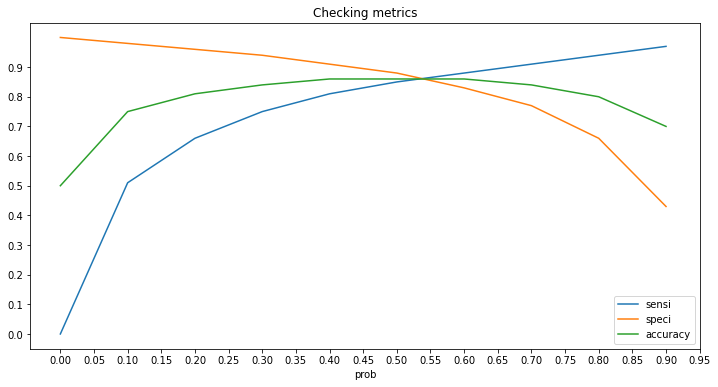

In [132]:
cutoff_df.plot.line(x='prob', y=['sensi', 'speci', 'accuracy'], figsize=(12, 6))
plt.xticks(np.arange(0, 1, 0.05))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='best')
plt.title('Checking metrics')
plt.show()

Optimum cutoff seems to be around 0.55

**For training data, the metrics seem to be ~0.85 for the optimum cutoff.**

Checking test data. Since SMOTE has not been applied on the test data, we need recall (sensitivity) to be high.

In [133]:
X_test_lr_reduced = X_test_lr[X_train_lr_reduced.columns]
y_test_lr_pred_prob = res.predict(sm.add_constant(X_test_lr_reduced))
y_test_lr_pred_final = y_test_lr_pred_prob.map(lambda y: 1 if y > 0.55 else 0)

In [134]:
evaluate(y_test_lr, y_test_lr_pred_final)


*** accuracy: 0.87

*** sensitivity: 0.87

              precision    recall  f1-score   support

           0       0.98      0.87      0.93      8167
           1       0.33      0.82      0.47       626

    accuracy                           0.87      8793
   macro avg       0.66      0.85      0.70      8793
weighted avg       0.94      0.87      0.89      8793


*** informedness: 0.7
*** ROC AUC: 0.85


**Sensitivity is 0.87 on test data with Logistic Regression.**

Get the top 10 predictors

In [135]:
abs(res.params).sort_values(ascending=False)[0: 16]

date_of_last_rech_8    0.743936
last_day_rch_amt_8     0.666893
monthly_3g_8           0.511750
roam_og_mou_8          0.493923
loc_og_t2m_mou_8       0.491829
spl_ic_mou_8           0.439186
monthly_2g_8           0.417684
arpu_7                 0.417468
aon                    0.384732
monthly_2g_6           0.366976
sachet_2g_8            0.346655
total_rech_num_diff    0.308083
const                  0.304132
total_ic_mou_8         0.289759
loc_ic_t2f_mou_8       0.280226
sachet_3g_8            0.261598
dtype: float64

Most of the important predictors are from August (the action phase), which matches the business context.

### Checking more complex models for improved performance.

## PCA

In [136]:
from sklearn.decomposition import PCA

In [137]:
pca = PCA(0.95)

In [138]:
pca.fit(X_train_base)

PCA(n_components=0.95)

In [139]:
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
y_train = y_train_sm

In [140]:
# X_train

In [141]:
pca.n_components_

31

Checking components that explain the most variance.

In [142]:
if False:
    var = pca.explained_variance_

    var


    pc1 = X_train[:,0]
    pc2 = X_train[:,1]

    #Plot principal components
    plt.figure(figsize=(10,10))

    colour = ['#ff2121' if a == 1 else '#2176ff' for a in y_train]
    plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')
    plt.yticks(size=12)
    plt.xticks(size=12)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

## Decision Tree

In [143]:
from sklearn.tree import DecisionTreeClassifier

In [144]:
dt_class = DecisionTreeClassifier()

In [145]:
data.shape

(29309, 148)

In [146]:
dt_class.fit(X_train, y_train)

DecisionTreeClassifier()

In [147]:
y_train_pred_dt = dt_class.predict(X_train)

In [148]:
evaluate(y_train, y_train_pred_dt)


*** accuracy: 1.0

*** sensitivity: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19055
           1       1.00      1.00      1.00     19055

    accuracy                           1.00     38110
   macro avg       1.00      1.00      1.00     38110
weighted avg       1.00      1.00      1.00     38110


*** informedness: 1.0
*** ROC AUC: 1.0


The model has most likely overfit. Confirm with test data.

In [149]:
y_test_pred_dt = dt_class.predict(X_test)

In [150]:
evaluate(y_test, y_test_pred_dt)


*** accuracy: 0.84

*** sensitivity: 0.87

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      8167
           1       0.23      0.51      0.32       626

    accuracy                           0.84      8793
   macro avg       0.59      0.69      0.61      8793
weighted avg       0.91      0.84      0.87      8793


*** informedness: 0.38
*** ROC AUC: 0.69


Accuracy has only dropped slightly, but ROC AUC has dropped significantly. So, test performance is not good. This indicates overfitting.

#### Hyperparameter tuning using cross-validation

In [151]:
from sklearn.model_selection import GridSearchCV

In [152]:
data.shape

(29309, 148)

In [215]:
if False:
    params = {
        'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
        'min_samples_leaf': [5, 10, 20, 50, 100, 250, 500, 800, 1000],
        'max_leaf_nodes': [1, 5, 10, 25, 50, 100]
    }

    dt_class = DecisionTreeClassifier(random_state=42)

    cv = GridSearchCV(
        estimator=dt_class,
        param_grid=params,
        n_jobs=-1,
        verbose=1,
        cv=4,
        scoring='accuracy'
    )

    cv.fit(X_train, y_train)

    dt_best = cv.best_estimator_

Fitting 4 folds for each of 486 candidates, totalling 1944 fits


In [216]:
# dt_best

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=5,
                       random_state=42)

In [217]:
# cv.best_score_

0.8324586428848603

In [201]:
# dt_best_2 = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=20, random_state=42)

In [197]:
# dt_best.min_samples_split

2

In [202]:
# dt_best_2.min_samples_split

2

In [218]:
# Got from running above cell previously
dt_best = DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=5, random_state=42)
dt_best.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=100, min_samples_leaf=5,
                       random_state=42)

In [219]:
y_train_pred_dt_best = dt_best.predict(X_train)

In [220]:
evaluate(y_train, y_train_pred_dt_best)


*** accuracy: 0.85

*** sensitivity: 0.84

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     19055
           1       0.84      0.86      0.85     19055

    accuracy                           0.85     38110
   macro avg       0.85      0.85      0.85     38110
weighted avg       0.85      0.85      0.85     38110


*** informedness: 0.7
*** ROC AUC: 0.85


Checking with test data

In [221]:
y_test_pred_dt_best = dt_best.predict(X_test)

In [222]:
evaluate(y_test, y_test_pred_dt_best)


*** accuracy: 0.81

*** sensitivity: 0.82

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      8167
           1       0.23      0.70      0.34       626

    accuracy                           0.81      8793
   macro avg       0.60      0.76      0.62      8793
weighted avg       0.92      0.81      0.85      8793


*** informedness: 0.52
*** ROC AUC: 0.76


### Random Forest

In [160]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
rf = RandomForestClassifier(random_state=42)

In [162]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [163]:
y_train_pred_rf = rf.predict(X_train)

In [164]:
evaluate(y_train, y_train_pred_rf)


*** accuracy: 1.0

*** sensitivity: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19055
           1       1.00      1.00      1.00     19055

    accuracy                           1.00     38110
   macro avg       1.00      1.00      1.00     38110
weighted avg       1.00      1.00      1.00     38110


*** informedness: 1.0
*** ROC AUC: 1.0


In [165]:
y_test_pred_rf = rf.predict(X_test)

In [166]:
evaluate(y_test, y_test_pred_rf)


*** accuracy: 0.91

*** sensitivity: 0.94

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8167
           1       0.41      0.54      0.47       626

    accuracy                           0.91      8793
   macro avg       0.69      0.74      0.71      8793
weighted avg       0.92      0.91      0.92      8793


*** informedness: 0.48
*** ROC AUC: 0.74


Since ROC AUC has dropped significantly, the RandomForest has overfit.

#### Random Forest with Cross validation

In [230]:
if False:
    params_rf = {
        'n_estimators': [10, 25, 50, 100],
        'max_depth': [2, 3, 5, 10, 20, 30],
        # 'min_samples_split': [2, 5, 10, 15, 20, 25, 50],
        'min_samples_leaf': [5, 10, 20, 50, 100]
    }

    rf_2 = RandomForestClassifier(random_state=42)

    cv_rf = GridSearchCV(
        estimator=rf_2,
        param_grid=params_rf,
        n_jobs=-1,
        verbose=1,
        cv=4,
        scoring='accuracy'
    )

    cv_rf.fit(X_train, y_train)

    rf_best = cv_rf.best_estimator_

Fitting 4 folds for each of 120 candidates, totalling 480 fits


In [231]:
# rf_best

RandomForestClassifier(max_depth=30, min_samples_leaf=5, random_state=42)

In [232]:
# rf_best.n_estimators

100

In [168]:
# Got from running above cell previously
rf_best = RandomForestClassifier(max_depth=30, min_samples_leaf=5, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=50, min_samples_split=15,
                       random_state=42)

In [233]:
y_train_pred_rf_best = rf_best.predict(X_train)

In [234]:
evaluate(y_train, y_train_pred_rf_best)


*** accuracy: 0.98

*** sensitivity: 0.97

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     19055
           1       0.97      0.99      0.98     19055

    accuracy                           0.98     38110
   macro avg       0.98      0.98      0.98     38110
weighted avg       0.98      0.98      0.98     38110


*** informedness: 0.96
*** ROC AUC: 0.98


Checking with test data.

In [235]:
y_test_pred_rf_best = rf_best.predict(X_test)

In [236]:
evaluate(y_test, y_test_pred_rf_best)


*** accuracy: 0.9

*** sensitivity: 0.93

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8167
           1       0.39      0.61      0.48       626

    accuracy                           0.90      8793
   macro avg       0.68      0.77      0.71      8793
weighted avg       0.93      0.90      0.91      8793


*** informedness: 0.54
*** ROC AUC: 0.77


Even though the ROC AUC has dropped from the training data, the sensitivity of 0.93 fits our purpose.

Therefore, we can use this Random Forest model as our predictor.

## Adaboost

In [173]:
from sklearn.ensemble import AdaBoostClassifier

In [174]:
shallow = DecisionTreeClassifier(random_state=42, max_depth=2)

In [181]:
ests = list(range(1, 200, 10))
ada_scores = pd.DataFrame(columns=['n', 'sensi', 'speci', 'accuracy'])
for x in ests:
    ada = AdaBoostClassifier(base_estimator=shallow, random_state=42, n_estimators=x)
    ada.fit(X_train, y_train)

    y_train_pred_ada = ada.predict(X_train)
    ada_scores.loc[x] = [x, get_sensitivity(y_train, y_train_pred_ada), get_specificity(y_train, y_train_pred_ada), get_accuracy(y_train, y_train_pred_ada)]


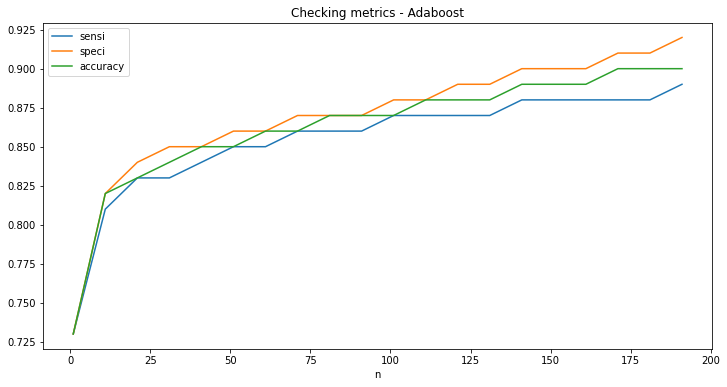

In [182]:
ada_scores.plot.line(x='n', y=['sensi', 'speci', 'accuracy'], figsize=(12, 6))
plt.legend(loc='best')
plt.title('Checking metrics - Adaboost')
plt.show()

Since sensitivity is still rising, checking with 200.

In [191]:
for x in range(20, 201, 20):
  ada_best = AdaBoostClassifier(base_estimator=shallow, n_estimators=x, random_state=42)
  ada_best.fit(X_train, y_train)
  y_test_pred_ada = ada_best.predict(X_test)
  print('*******************************')
  print(f'*** Num of Estimators: {x} ***')
  evaluate(y_test, y_test_pred_ada)
  print('')

*******************************
*** Num of Estimators: 20 ***

*** accuracy: 0.82

*** sensitivity: 0.82

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8167
           1       0.24      0.75      0.37       626

    accuracy                           0.82      8793
   macro avg       0.61      0.78      0.63      8793
weighted avg       0.92      0.82      0.86      8793


*** informedness: 0.57
*** ROC AUC: 0.78

*******************************
*** Num of Estimators: 40 ***

*** accuracy: 0.83

*** sensitivity: 0.83

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8167
           1       0.25      0.73      0.37       626

    accuracy                           0.83      8793
   macro avg       0.61      0.78      0.64      8793
weighted avg       0.92      0.83      0.86      8793


*** informedness: 0.57
*** ROC AUC: 0.78

*******************************
*** Num of Estim


*** accuracy: 0.84

*** sensitivity: 0.85

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      8167
           1       0.27      0.70      0.38       626

    accuracy                           0.84      8793
   macro avg       0.62      0.78      0.65      8793
weighted avg       0.92      0.84      0.87      8793


*** informedness: 0.55
*** ROC AUC: 0.78


## XGBoost

## Build Logistic Regression model to interpret

In [ ]:
import statsmodels.api as sm

In [ ]:
y_train_sm.value_counts()

In [ ]:
logit = sm.Logit(y_train_sm, X_train_sm)
result = logit.fit(method='bfgs')

## RandomForest - ???

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
if False:
    params_rf = {
        'max_depth': [2, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 15, 20],
        'max_leaf_nodes': [2, 5, 10, 15, 20]
    }

    rf_3 = RandomForestClassifier(random_state=42)

    cv_rf_int = GridSearchCV(
        estimator=rf_2,
        param_grid=params_rf,
        n_jobs=-1,
        return_train_score=True,
        verbose=2
    )

    cv_rf_int.fit(X_train_sm, y_train_sm)

In [ ]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train_sm, y_train_sm)

In [ ]:
sel.get_support()

In [ ]:
X_train_sm.columns[sel.get_support()]

In [ ]:
y_train_pred_rf_int = sel.estimator.predict(X_train_sm)

Repeating the 3 models above.

Logistic Regression

In [ ]:
logreg_sm = LogisticRegression(random_state=42)
logreg_sm.fit(X_sm, y_sm)
y_sm_pred_log = logreg_sm.predict(X_sm)
evaluate(y_sm, y_sm_pred_log)

Decision Tree

In [ ]:
if False:
    params_sm = {
        'max_depth': [7, 8, 9, 10, 11],
        'min_samples_split': [2, 5, 10, 15, 20],
        'max_leaf_nodes': [30, 31, 32, 33, 34, 35]
    }

    dt_sm = DecisionTreeClassifier(random_state=42)

    cv_sm = GridSearchCV(
        estimator=dt_sm,
        param_grid=params_sm,
        n_jobs=-1,
        return_train_score=True,
        verbose=2
    )

    cv_sm.fit(X_sm, y_sm)

    dt_sm_best = cv_sm.best_estimator_

    dt_sm_best

In [ ]:
# Got from running above cell previously
dt_sm_best = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=35, random_state=42)
dt_sm_best.fit(X_sm, y_sm)

In [ ]:
y_train_pred_dt_sm_best = dt_sm_best.predict(X_sm)
evaluate(y_sm, y_train_pred_dt_sm_best)

Random Forest

In [ ]:
if False:
    params_rf_sm = {
        'max_depth': [8, 9, 10, 11, 12],
        'min_samples_split': [18, 19, 20, 21, 22],
        'max_leaf_nodes': [40, 45, 50, 55]
    }

    rf_sm_2 = RandomForestClassifier(random_state=42)

    cv_rf_sm = GridSearchCV(
        estimator=rf_sm_2,
        param_grid=params_rf_sm,
        n_jobs=-1,
        return_train_score=True,
        verbose=2
    )

    cv_rf_sm.fit(X_sm, y_sm)

    rf_sm_best = cv_rf_sm.best_estimator_

    rf_sm_best

In [ ]:
# Got from running above cell previously
rf_sm_best = RandomForestClassifier(max_depth=10, max_leaf_nodes=55, min_samples_split=20, random_state=42)
rf_sm_best.fit(X_sm, y_sm)

In [ ]:
y_train_pred_rf_sm_best = rf_sm_best.predict(X_sm)
evaluate(y_sm, y_train_pred_rf_sm_best)

#### Check with test data

In [ ]:
y_test_pred_logref_sm = logreg_sm.predict(X_test)
evaluate(y_test, y_test_pred_logref_sm)

In [ ]:
y_test_pred_dt_sm_best = dt_sm_best.predict(X_test)

In [ ]:
evaluate(y_test, y_test_pred_dt_sm_best)

In [ ]:
y_test_pred_rf_sm_best = rf_sm_best.predict(X_test)

In [ ]:
evaluate(y_test, y_test_pred_rf_sm_best)

### Evaluation

Since it is important not to misclassify churns, we use <>

What about F1-score? How does it tie into class imbalance, and does it cover not misclassifying churn?